In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
import html
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/siyu/Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


#Data Preprocessing

In [ ]:
# Keep the desired columns
data = data[['text','Openness to Experience', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism', 'class']]

# Encode the 'class' column as a numeric type
data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})

# Remove the percentage symbols and convert the data to floating numbers
data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
data['Conscientiousness'] = data['Conscientiousness'].str.rstrip('%').astype(float)
data['Extraversion'] = data['Extraversion'].str.rstrip('%').astype(float)
data['Agreeableness'] = data['Agreeableness'].str.rstrip('%').astype(float)
data['Neuroticism'] = data['Neuroticism'].str.rstrip('%').astype(float)

# Check the data type of each column
print(data.dtypes)
data

text                       object
Openness to Experience    float64
Conscientiousness         float64
Extraversion              float64
Agreeableness             float64
Neuroticism               float64
class                       int64
dtype: object


<ipython-input-5-31a2014aacae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})
<ipython-input-5-31a2014aacae>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
<ipython-input-5-31a2014aacae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,text,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism,class
0,Ex Wife Threatening SuicideRecently I left my ...,51.0,68.0,27.0,35.0,67.0,1
1,Am I weird I don't get affected by compliments...,98.0,0.0,1.0,17.0,100.0,0
2,Finally 2020 is almost over... So I can never ...,89.0,7.0,1.0,11.0,56.0,0
3,"Everyone wants to be ""edgy"" and it's making me...",97.0,12.0,22.0,26.0,93.0,0
4,I took the rest of my sleeping pills and my pa...,98.0,69.0,0.0,63.0,90.0,1
...,...,...,...,...,...,...,...
995,I'm a 17 year old senior and I sometimes feel ...,75.0,37.0,26.0,36.0,85.0,1
996,I just want to go to sleep and not wake upI ha...,76.0,21.0,0.0,17.0,97.0,1
997,Help. I'm so lost.I feel so helpless despite t...,88.0,25.0,18.0,15.0,99.0,1
998,Anybody else get really scared when you get cl...,98.0,41.0,49.0,54.0,98.0,1


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


# Modeling

##1. TF-IDF + XGBoost

In [ ]:
y = data['class']
X_train1, X_test1, y_train1, y_test1 = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)


In [ ]:
# TF-IDF parameter optimization

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [3, 5, 10],
    'tfidf__max_features': [None, 5000, 10000]
}

vectorizer = TfidfVectorizer()
clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

pipeline = Pipeline([('tfidf', vectorizer), ('clf', clf)])

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train1, y_train1)

print("Best parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters:  {'tfidf__max_df': 0.5, 'tfidf__max_features': None, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}


In [ ]:
# Train set and test set split
X_train, X_test, y_train, y_test = train_test_split(data[['preprocessed_text', 'Extraversion', 'Agreeableness', 'Neuroticism']], y, test_size=0.2, random_state=42)


In [ ]:
# TF-IDF feature extraction
best_vectorizer = TfidfVectorizer(**{k[7:]: v for k, v in grid_search.best_params_.items() if k.startswith('tfidf__')})
X_train_tfidf = best_vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_tfidf = best_vectorizer.transform(X_test['preprocessed_text'])

# Combine TF-IDF features & Big 5 personality scores
X_train_combined_tfidf = np.concatenate((X_train_tfidf.toarray(), X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]), axis=1)
X_test_combined_tfidf = np.concatenate((X_test_tfidf.toarray(), X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]), axis=1)


In [ ]:
# TF-IDF + XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_combined_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_combined_tfidf)
print('TF-IDF + XGBoost Results:')
print(classification_report(y_test, y_pred_xgb, digits=4))

TF-IDF + XGBoost Results:
              precision    recall  f1-score   support

           0     0.8763    0.9140    0.8947        93
           1     0.9223    0.8879    0.9048       107

    accuracy                         0.9000       200
   macro avg     0.8993    0.9009    0.8997       200
weighted avg     0.9009    0.9000    0.9001       200



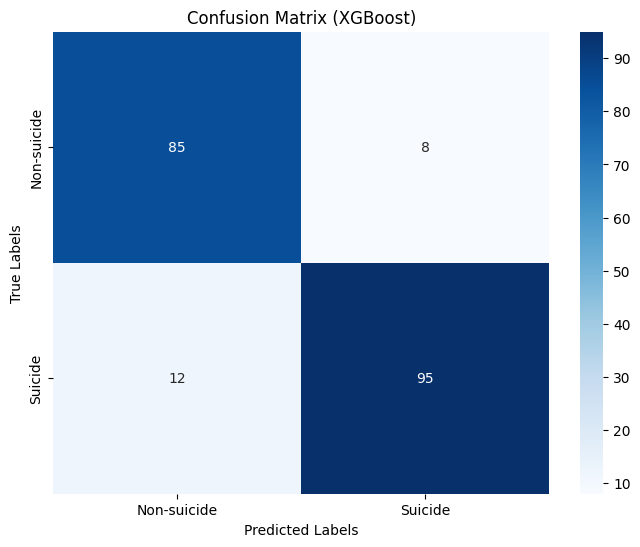

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

##2. TF-IDF + Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

# Use grid search to find the best parameters
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_combined_tfidf, y_train)

print("Best parameters for Random Forest: ", rf_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# Retrain the model using the best parameters
rf_best = RandomForestClassifier(**rf_grid_search.best_params_, random_state=42)
rf_best.fit(X_train_combined_tfidf, y_train)
y_pred_rf = rf_best.predict(X_test_combined_tfidf)
print('TF-IDF + Random Forest Results:')
print(classification_report(y_test, y_pred_rf, digits=4))

TF-IDF + Random Forest Results:
              precision    recall  f1-score   support

           0     0.9362    0.9462    0.9412        93
           1     0.9528    0.9439    0.9484       107

    accuracy                         0.9450       200
   macro avg     0.9445    0.9451    0.9448       200
weighted avg     0.9451    0.9450    0.9450       200



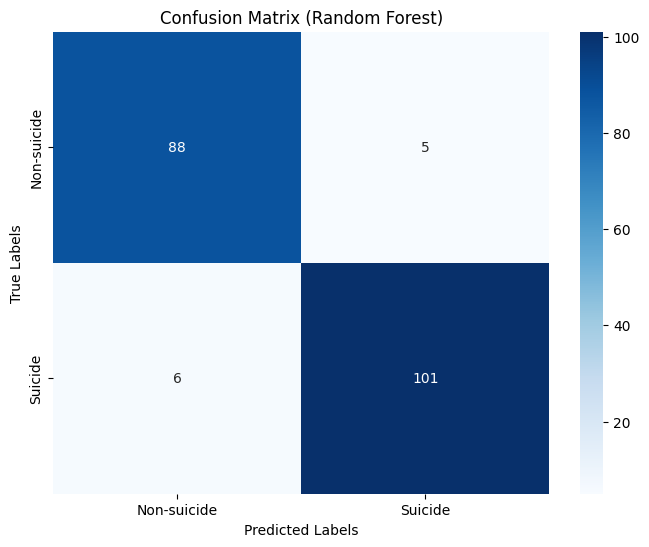

In [ ]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

##3. Word2Vec + CNN-BiLSTM

In [ ]:
from gensim.models import KeyedVectors

# Train set and test set split
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(data[['preprocessed_text', 'Extraversion', 'Agreeableness', 'Neuroticism']], y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['preprocessed_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['preprocessed_text'])

max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Extract Big 5 personality scores
train_scores = X_train[['Extraversion', 'Agreeableness', 'Neuroticism']].values
test_scores = X_test[['Extraversion', 'Agreeableness', 'Neuroticism']].values

# Load GoogleNews pre-trained word vectors
word2vec_path = '/content/drive/MyDrive/siyu/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Create the word embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [ ]:
!pip install optuna
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import optuna

# Define the function that creates the model
def create_model(lstm_units, dense_units, dropout_rate):
    text_input = Input(shape=(max_length,), name='text_input')
    x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
    x = Conv1D(100, 5, activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))(x)

    personality_input = Input(shape=(3,), name='personality_input')
    p = Dense(32, activation='relu')(personality_input)

    combined = Concatenate()([x, p])

    x = Dense(dense_units, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[text_input, personality_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the target function
def objective(trial):
    # Hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 100, 150)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    model = create_model(lstm_units, dense_units, dropout_rate)

    # Train the model
    model.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
              batch_size=32,
              epochs=10,
              verbose=0)

    # Evaluate the model
    scores = model.evaluate([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_test, verbose=0)
    return scores[1]

# Creat Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


[I 2024-06-04 09:25:11,644] A new study created in memory with name: no-name-0581cf6a-7d43-4ce8-9046-8b2eaeae4b62
[I 2024-06-04 09:25:43,239] Trial 0 finished with value: 0.8949999809265137 and parameters: {'lstm_units': 124, 'dense_units': 77, 'dropout_rate': 0.4755013137615519}. Best is trial 0 with value: 0.8949999809265137.
[I 2024-06-04 09:26:15,019] Trial 1 finished with value: 0.9049999713897705 and parameters: {'lstm_units': 118, 'dense_units': 35, 'dropout_rate': 0.5212663529735015}. Best is trial 1 with value: 0.9049999713897705.
[I 2024-06-04 09:26:43,565] Trial 2 finished with value: 0.9100000262260437 and parameters: {'lstm_units': 110, 'dense_units': 102, 'dropout_rate': 0.396243460915943}. Best is trial 2 with value: 0.9100000262260437.
[I 2024-06-04 09:27:14,755] Trial 3 finished with value: 0.925000011920929 and parameters: {'lstm_units': 141, 'dense_units': 49, 'dropout_rate': 0.3254288742698619}. Best is trial 3 with value: 0.925000011920929.
[I 2024-06-04 09:27:41,5

Best trial:
  Value:  0.9399999976158142
  Params: 
    lstm_units: 140
    dense_units: 86
    dropout_rate: 0.4937766522445167


In [ ]:
# Retrain the model using the best parameters
best_params = study.best_params
model = create_model(best_params['lstm_units'], best_params['dense_units'], best_params['dropout_rate'])
model.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], y_train,
          batch_size=32,
          epochs=20)

# Evaluate the model on the test set
y_prob = model.predict([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test_labels, y_pred, digits=4))

Epoch 1/20
25/25 [==============================] - 8s 110ms/step - loss: 2.5154 - accuracy: 0.5938
Epoch 2/20
25/25 [==============================] - 3s 120ms/step - loss: 1.2211 - accuracy: 0.6112
Epoch 3/20
25/25 [==============================] - 3s 117ms/step - loss: 0.6684 - accuracy: 0.7050
Epoch 4/20
25/25 [==============================] - 2s 98ms/step - loss: 0.4794 - accuracy: 0.7925
Epoch 5/20
25/25 [==============================] - 2s 97ms/step - loss: 0.3609 - accuracy: 0.8512
Epoch 6/20
25/25 [==============================] - 2s 97ms/step - loss: 0.3698 - accuracy: 0.8637
Epoch 7/20
25/25 [==============================] - 2s 97ms/step - loss: 0.3054 - accuracy: 0.8950
Epoch 8/20
25/25 [==============================] - 3s 110ms/step - loss: 0.2860 - accuracy: 0.9013
Epoch 9/20
25/25 [==============================] - 3s 110ms/step - loss: 0.2148 - accuracy: 0.9350
Epoch 10/20
25/25 [==============================] - 2s 98ms/step - loss: 0.1767 - accuracy: 0.9463
Epoc

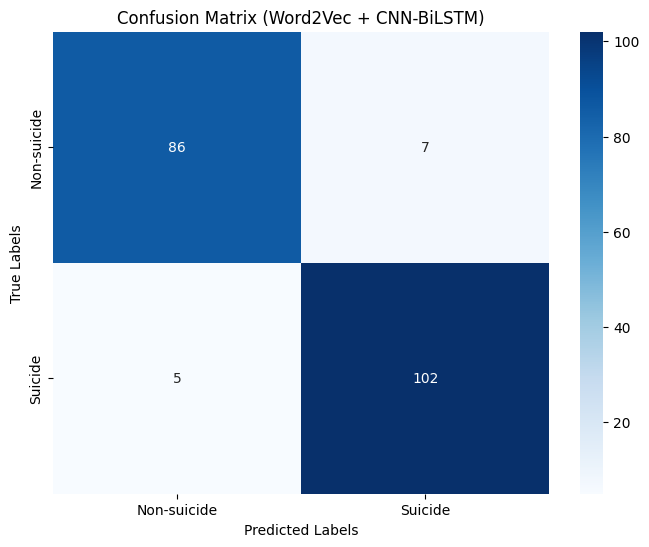

In [ ]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM)')
plt.show()

##4. BERT

In [ ]:
# BERT preprocessor does not require stopword, punctuation removal or tokenization, lemmatization
def preprocess_bert(text):
    tokenizer = TweetTokenizer(reduce_len=True)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Lowercasing
    text = text.lower()

    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in ['"','#ff', 'ff', 'rt']]
    text = ' '.join(tokens)

    return text

data['preprocessed_text_bert'] = data.text.apply(preprocess_bert)
data[['text','preprocessed_text_bert']].head(10)

,text,preprocessed_text_bert
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,am i weird i don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,finally 2020 is almost over ... so i can never...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone wants to be edgy and it's making me s...
4,I took the rest of my sleeping pills and my pa...,i took the rest of my sleeping pills and my pa...
5,Can you imagine getting old? Me neither.Wrinkl...,can you imagine getting old ? me neither.wrink...
6,Do you think getting hit by a train would be p...,do you think getting hit by a train would be p...
7,"death, continuedI posted here before and saw s...","death , continuedi posted here before and saw ..."
8,Fuck the verizon smart family app I can’t even...,fuck the verizon smart family app i can ’ t ev...
9,I’m scared. Everything just seems to be gett...,i ’ m scared . everything just seems to be get...


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.metrics import classification_report
import pandas as pd

# Process the labels, making sure all labels are between 0 and 1
labels = data['class']

# Processing text
texts = data['preprocessed_text_bert']
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the text data as BERT input
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Handle additional features
extra_features = data[['Extraversion', 'Agreeableness', 'Neuroticism']].values
extra_features = torch.tensor(extra_features, dtype=torch.float32)

# Create the label tensor and make sure it's a Long
labels = torch.tensor(labels, dtype=torch.long)

# Creat TensorDataset
dataset = TensorDataset(input_ids, attention_masks, extra_features, labels)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=8)

# Define the model
class BertWithExtraFeatures(nn.Module):
    def __init__(self, bert_model, extra_feature_size, num_labels):
        super(BertWithExtraFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.extra_feature_size = extra_feature_size
        self.num_labels = num_labels

        self.classifier = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size + extra_feature_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, extra_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        combined_output = torch.cat((pooled_output, extra_features), dim=1)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)
        return logits

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2)

# Use CUDA (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Train and validate the model
for epoch in range(10):
    # Train the loop
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        model.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_extra_features)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} finished.")

    # Validate the loop
    model.eval()
    val_labels = []
    val_preds = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)

        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT with personality Results:')
print(classification_report(val_labels, val_preds, digits=4))

Epoch 1 finished.
Epoch 2 finished.
Epoch 3 finished.
Epoch 4 finished.
Epoch 5 finished.
Epoch 6 finished.
Epoch 7 finished.
Epoch 8 finished.
Epoch 9 finished.
Epoch 10 finished.
BERT with personality Results:
              precision    recall  f1-score   support

           0     0.9083    0.9706    0.9384       102
           1     0.9670    0.8980    0.9312        98

    accuracy                         0.9350       200
   macro avg     0.9376    0.9343    0.9348       200
weighted avg     0.9371    0.9350    0.9349       200



#### Hyperparameter optimization

In [ ]:
!pip install optuna

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.metrics import classification_report
import pandas as pd
import optuna

# Processing text
texts = data['preprocessed_text_bert']
labels = data['class']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the text data as BERT input
encoded_data = tokenizer.batch_encode_plus(
    texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Handle additional features
extra_features = data[['Extraversion', 'Agreeableness', 'Neuroticism']].values
extra_features = torch.tensor(extra_features, dtype=torch.float32)

# Create the label tensor
labels = torch.tensor(labels, dtype=torch.long)

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, extra_features, labels)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=8)

# Define the model
class BertWithExtraFeatures(nn.Module):
    def __init__(self, bert_model, extra_feature_size, num_labels, dropout_rate):
        super(BertWithExtraFeatures, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout_rate)
        self.extra_feature_size = extra_feature_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size + extra_feature_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, extra_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        combined_output = torch.cat((pooled_output, extra_features), dim=1)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)
        return logits

# Hyperparameter optimization using Optuna
def objective(trial):
    # Hyperparameter Search space
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)  # Expand the scope
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)  # Expand the scope

    # Initialize the BERT model
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2, dropout_rate=dropout_rate)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    total_steps = len(train_dataloader) * 3  # Suppose 3 epochs are trained for hyperparameter search
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    # Train the model
    for epoch in range(3):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_extra_features, b_labels = batch

            optimizer.zero_grad()
            logits = model(b_input_ids, b_input_mask, b_extra_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

    # Evaluate the model
    model.eval()
    val_labels = []
    val_preds = []
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

    f1 = f1_score(val_labels, val_preds, average='weighted')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase the number of attempts

best_params = study.best_params
print(f"Best Parameters: {best_params}")

[I 2024-05-19 08:49:12,659] A new study created in memory with name: no-name-aa7c4602-6de3-4577-963f-1293b0fbc92e
<ipython-input-17-dab45bbeb494>:76: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)  # 扩大范围
<ipython-input-17-dab45bbeb494>:77: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-17-dab45bbeb494>:78: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 

Best Parameters: {'lr': 6.517280943851091e-05, 'dropout_rate': 0.15928830739588556, 'weight_decay': 1.4485120180652067e-06}


In [ ]:
# Retrin the model using the best hyperparameters
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2, dropout_rate=best_params['dropout_rate'])
model.to(device)

optimizer = AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Train and evaluate the model
for epoch in range(10):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        optimizer.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_extra_features)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss / len(train_dataloader)}")

    model.eval()
    val_labels = []
    val_preds = []
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT with personality & best params Results:')
print(classification_report(val_labels, val_preds, digits=4))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 finished. Loss: 0.4037238028459251
Epoch 2 finished. Loss: 0.2390745561942458
Epoch 3 finished. Loss: 0.17509686637669802
Epoch 4 finished. Loss: 0.17283241022378207
Epoch 5 finished. Loss: 0.16960074450820684
Epoch 6 finished. Loss: 0.161011917963624
Epoch 7 finished. Loss: 0.16313926506787538
Epoch 8 finished. Loss: 0.16860747542232274
Epoch 9 finished. Loss: 0.16289163161069153
Epoch 10 finished. Loss: 0.16550238914787768
BERT with personality & best params Results:
              precision    recall  f1-score   support

           0     0.9674    0.9082    0.9368        98
           1     0.9167    0.9706    0.9429       102

    accuracy                         0.9400       200
   macro avg     0.9420    0.9394    0.9398       200
weighted avg     0.9415    0.9400    0.9399       200



Use early stopping mechanism

In [ ]:
# Retrin the model using the best hyperparameters
bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BertWithExtraFeatures(bert_model, extra_feature_size=3, num_labels=2, dropout_rate=best_params['dropout_rate'])
model.to(device)

optimizer = AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Early stopping
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Train and evaluate the model
for epoch in range(10):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        optimizer.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_extra_features)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss / len(train_dataloader)}")

    # Evaluate the model
    model.eval()
    val_labels = []
    val_preds = []
    val_loss = 0
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_extra_features, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask, b_extra_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)
            val_loss += loss.item()
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

    avg_val_loss = val_loss / len(validation_dataloader)
    print(f"Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

print('BERT with personality & best params Results:')
print(classification_report(val_labels, val_preds, digits=4))

Epoch 1 finished. Loss: 0.3970088729634881
Validation Loss: 0.16501084402203559
Epoch 2 finished. Loss: 0.1447610628604889
Validation Loss: 0.13806575328111648
Epoch 3 finished. Loss: 0.08990870451554656
Validation Loss: 0.13962651148438454
Epoch 4 finished. Loss: 0.09271471840329468
Validation Loss: 0.1409931416809559
Epoch 5 finished. Loss: 0.08752960443496705
Validation Loss: 0.14100792191922665
Epoch 6 finished. Loss: 0.0844825460202992
Validation Loss: 0.14100806906819344
Epoch 7 finished. Loss: 0.08578966921195388
Validation Loss: 0.14100812196731569
Epoch 8 finished. Loss: 0.07827223697677255
Validation Loss: 0.14100809618830681
Epoch 9 finished. Loss: 0.09126331467181444
Validation Loss: 0.14100812271237373
Epoch 10 finished. Loss: 0.08609796794131398
Validation Loss: 0.14100812926888465
BERT with personality & best params Results:
              precision    recall  f1-score   support

           0     0.9787    0.9388    0.9583        98
           1     0.9434    0.9804    0.

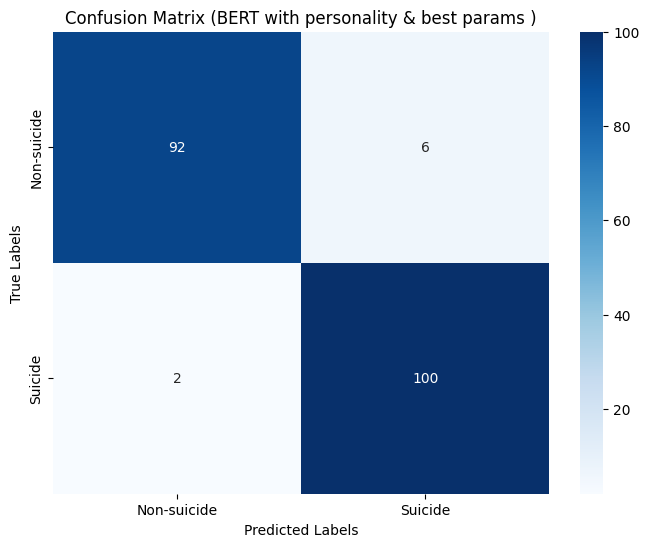

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT with personality & best params )')
plt.show()